In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit, njit, prange
from tqdm import trange
from numpy.random import default_rng
from queue import Queue
import time

In [7]:
def set_grid(N, seed=69):
    rng = default_rng(seed=69)
    spins = rng.choice([-1,1],size=(N,N)).astype(dtype=int)
    return spins

In [8]:
@njit
def Ealphak(s,J=1.0,B=0.,mub=1.0,N=100):
    Eres=0.
    for i in prange(N):
        for j in range(N):
            Eres+=-J*s[i,j]*s[i,(j+1)%N]-J*s[i,j]*s[(i+1)%N,j]-B*mub*s[i,j]
    return Eres

In [94]:
def update_grid(N, grid, rng, J=1.,B=0.,mub=1., k=1., T=5.):
    init=(rng.choice(np.arange(N)),rng.choice(np.arange(N)))
    q = Queue()
    q.put(init)
    cluster = set()
    cluster.add(init)
    grid[init]*=-1
    while not q.empty():
        x, y = q.get()
        for w in [((x-1)%N,y),(x,(y-1)%N),((x+1)%N,y),(x,(y+1)%N)]: 
            if w in cluster:
                continue
            if grid[w] != grid[x,y]:
                p=rng.uniform()
                R = 1.0 - np.exp(-2/T)
                if R>=p:
                    grid[w]*=-1
                    cluster.add(w)
                    q.put(w)
            else:
                continue
    return grid

In [180]:
def avgE(N, s, J=1.,B=0.,mub=1., k=1., T=5., eps=1e-2, window=500, maxiter=10000):
    grid = s
    maxcounter = maxiter
    x = np.arange(maxcounter)
    E = np.zeros(maxcounter)
    Mu = []
    rng = default_rng(69)
    for i in range(window):
        Mu.append(np.abs((1/(N*N))*np.sum(grid)))
        E[i] = Ealphak(grid, J=J,B=B,mub=mub,N=N)/(N*N)
        grid = update_grid(N, grid, rng, J=J,B=B,mub=mub, k=k, T=T)
    counter = window
    while counter < maxcounter:
        Mu.append(np.abs(np.sum(grid)/(N*N)))
        E[counter] = Ealphak(grid, J=J,B=B,mub=mub,N=N)
        grid = update_grid(N, grid, rng, J=J,B=B,mub=mub, k=k, T=T)
        if (1/(window-1))*np.sum((E[counter-window:counter]/(N*N) - np.mean(E[counter-window:counter]/(N*N)))**2) < eps:
            break
        counter+=1
    Eav = np.mean(E[counter-window:counter]/(N*N))
    C = (1/(N*N*k*T*T))*(np.mean(E[counter-window:counter]**2)-np.mean(E[counter-window:counter])**2)
    Mures = np.mean(np.array(Mu)[-window:])
    return Eav, C, Mures, grid

In [181]:
N = 40
nx = 100
s0 = set_grid(N, seed=69)
T = np.linspace(6.0, 1.0, nx)
x = np.arange(nx)
E = np.zeros_like(T)
C = np.zeros_like(T)
Mu = np.zeros_like(T)
for i in trange(nx):
    E[i], C[i], Mu[i], s0  = avgE(N, s0, T=T[i],window=1000, eps=1e-7, maxiter=50000)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:36<00:00,  4.56s/it]


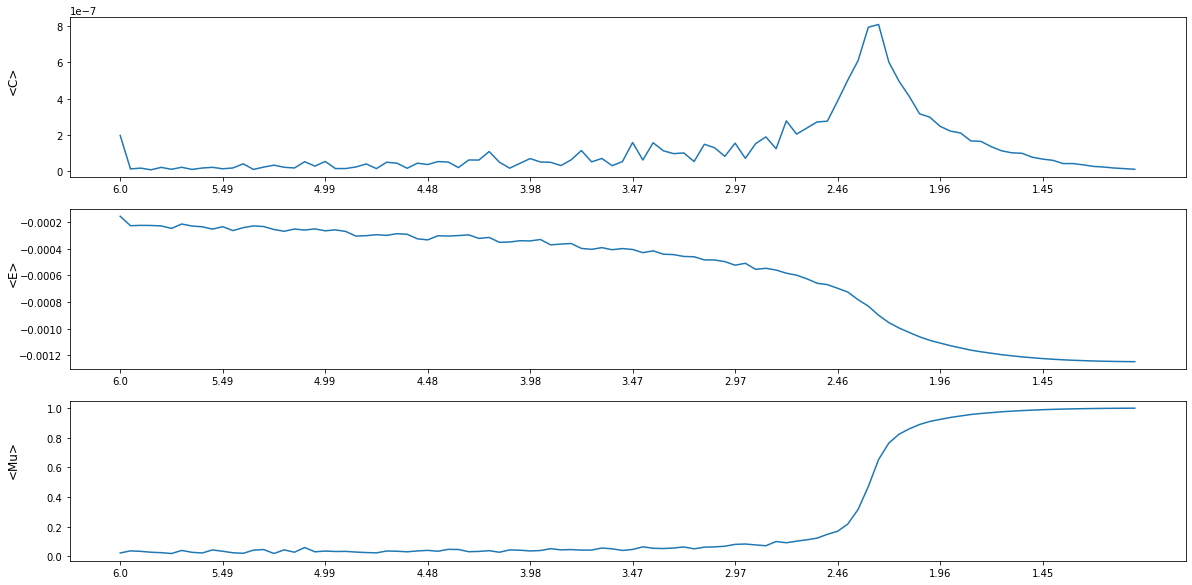

In [182]:
plt.figure(figsize=(20,10), edgecolor='0')
plt.subplot(311)
plt.title("<C>", x=-0.05,y=0.5,rotation='vertical')
plt.plot(x,C)
plt.xticks(ticks=x[::dx], labels=np.round(T[::dx],decimals=2))
plt.subplot(312)
plt.title("<E>", x=-0.05,y=0.5,rotation='vertical')
plt.plot(x,E)
plt.xticks(ticks=x[::dx], labels=np.round(T[::dx],decimals=2))
plt.subplot(313)
plt.title("<Mu>", x=-0.05,y=0.5,rotation='vertical')
plt.plot(x,Mu)
plt.xticks(ticks=x[::dx], labels=np.round(T[::dx],decimals=2))
plt.show()

In [185]:
N = 50
nx = 150
s0 = set_grid(N, seed=69)
T = np.linspace(6.0, 0.01, nx)
x = np.arange(nx)
E = np.zeros_like(T)
C = np.zeros_like(T)
Mu = np.zeros_like(T)
for i in trange(nx):
    E[i], C[i], Mu[i], s0  = avgE(N, s0, T=T[i],window=5000, eps=1e-7, maxiter=100000)

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [2:06:58<00:00, 50.79s/it]


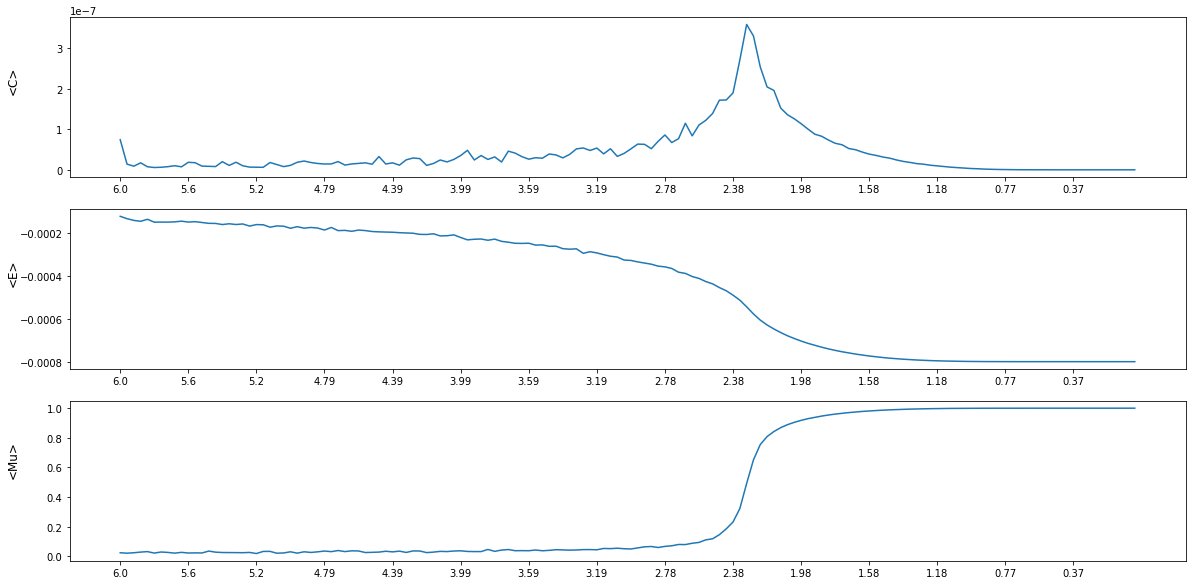

In [186]:
plt.figure(figsize=(20,10), edgecolor='0')
plt.subplot(311)
plt.title("<C>", x=-0.05,y=0.5,rotation='vertical')
plt.plot(x,C)
plt.xticks(ticks=x[::dx], labels=np.round(T[::dx],decimals=2))
plt.subplot(312)
plt.title("<E>", x=-0.05,y=0.5,rotation='vertical')
plt.plot(x,E)
plt.xticks(ticks=x[::dx], labels=np.round(T[::dx],decimals=2))
plt.subplot(313)
plt.title("<Mu>", x=-0.05,y=0.5,rotation='vertical')
plt.plot(x,Mu)
plt.xticks(ticks=x[::dx], labels=np.round(T[::dx],decimals=2))
plt.show()

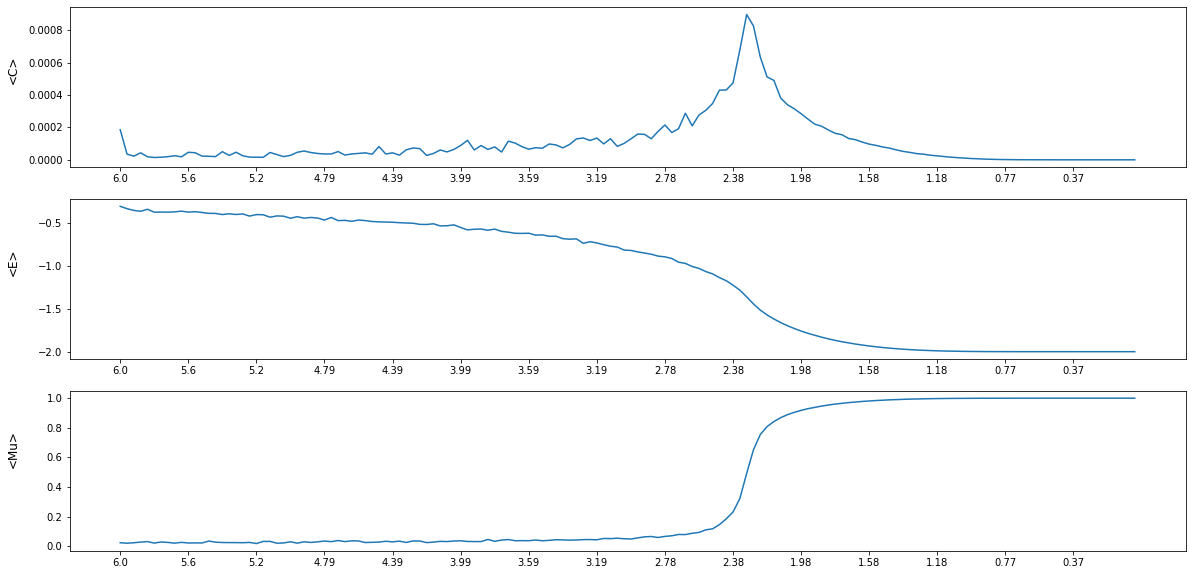

In [187]:
plt.figure(figsize=(20,10), edgecolor='0')
plt.subplot(311)
plt.title("<C>", x=-0.05,y=0.5,rotation='vertical')
plt.plot(x,C*N*N)
plt.xticks(ticks=x[::dx], labels=np.round(T[::dx],decimals=2))
plt.subplot(312)
plt.title("<E>", x=-0.05,y=0.5,rotation='vertical')
plt.plot(x,E*N*N)
plt.xticks(ticks=x[::dx], labels=np.round(T[::dx],decimals=2))
plt.subplot(313)
plt.title("<Mu>", x=-0.05,y=0.5,rotation='vertical')
plt.plot(x,Mu)
plt.xticks(ticks=x[::dx], labels=np.round(T[::dx],decimals=2))
plt.show()